In [23]:
import pandas as pd

In [24]:
path = r"Z:\sibroot\repo\personal\Course Conflict Scheduler\4 year Offerings.xlsx"
course_param = pd.read_excel(path, 'Course Parameters')
schedule_param = pd.read_excel(path, 'Schedule Parameters')
schedule_4270 = pd.read_excel(path, 'Lab Hours 4270')
schedule_4270.fillna(0)
schedule_4290 = pd.read_excel(path, 'Lab Hours 4290')
schedule_4290.fillna(0)
schedule_4345 = pd.read_excel(path, 'Lab Hours 4345')
schedule_4345.fillna(0)

,Name,Mon Start,Mon End,Tues Start,Tues End,Wed Start,Wed End,Thurs Start,Thurs End,Fri Start,Fri End
0,C1,830.0,1130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C2,1230.0,1530.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C3,1630.0,1930.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C4,0.0,0.0,830.0,1130.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C5,0.0,0.0,1230.0,1530.0,0.0,0.0,0.0,0.0,0.0,0.0
5,C6,0.0,0.0,1630.0,1930.0,0.0,0.0,0.0,0.0,0.0,0.0
6,C7,0.0,0.0,0.0,0.0,830.0,1130.0,0.0,0.0,0.0,0.0
7,C8,0.0,0.0,0.0,0.0,1230.0,1530.0,0.0,0.0,0.0,0.0
8,C9,0.0,0.0,0.0,0.0,1630.0,1930.0,0.0,0.0,0.0,0.0
9,C10,0.0,0.0,0.0,0.0,0.0,0.0,830.0,1130.0,0.0,0.0


In [25]:
def termSelector(courses, term, value):
    term_courses = courses[courses['Courses'].str.contains('MSE')]
    term_courses = term_courses[courses[term] == value]
    return term_courses

def scheduleSelector(schedules, header, duration): # return schedules only matching duration
    s = schedules[schedules[header].isin(duration)]
    return(s)

In [26]:
# sort schedules so that "lunch time" schedules are near the end, oPtimIzaTion
def sortdfschedule(adf):
    lunchstart = 1030
    lunchend = 1430
    for index, row in adf.iterrows():
        days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
        for day in days:
            startinlunch = row[day+' Start'] > lunchstart and row[day+' Start'] < lunchend
            endinlunch = row[day+' End'] > lunchstart and row[day+' End'] < lunchend
            if startinlunch and endinlunch:
                adf.loc[index, 'islunch'] = 2
            elif startinlunch or endinlunch:
                adf.loc[index, 'islunch'] = 1
            else:
                adf.loc[index, 'islunch'] = 0
            # print(row[day+' Start'], row[day+' Start']%50)
            if row[day+' Start'] % 50 == 30:
                adf.loc[index, day+' Start'] += 20
            if row[day+' End'] % 50 == 30:
                adf.loc[index, day+' End'] += 20
    adf.sort_values(by = ['islunch'], inplace = True)
    return adf

def df2dict(adf): #convert dataframe of schedules to dictionary ordered by schedule name, sorted by if they are during lunch time or not
    adf = sortdfschedule(adf)
    adf = adf.set_index('Name')
    adf = adf.fillna(0)
    adf = adf.to_dict(orient = 'index')
    return adf

def mergeDict(dict1, dict2):
    res = dict1 | dict2
    return res

def sortcourses(adf):
    for index, row in adf.iterrows():
        adf.loc[index, 'Weekly Total Duration'] = adf.loc[index, 'Weekly Class Duration'] + adf.loc[index, 'Weekly Tutorial Duration'] + adf.loc[index, 'Weekly Lab Duration'] * adf.loc[index, 'Number of Weekly Labs']
    adf.sort_values(by=['Weekly Total Duration'], inplace = True, ascending = False)
    return adf

term = 'Summer'
term2 = ''
if term == 'Summer':
    term2 = 'Summer'
else:
    term2 = 'Fall&Spring'

# classes with 3hrs set as credit3 due to previous assumption that classe length are based on credits
credit3 = scheduleSelector(schedule_param, 'Total Weekly Duration', [160,170])
credit3 = scheduleSelector(credit3, 'Term', ['All Terms', term])
credit3 = df2dict(credit3)

credit4 = scheduleSelector(schedule_param, 'Total Weekly Duration', [230])
credit4 = scheduleSelector(credit4, 'Term', ['All Terms', term2])
credit4 = df2dict(credit4)

schedule_4270 = df2dict(schedule_4270)
schedule_4290 = df2dict(schedule_4290)
schedule_4345 = df2dict(schedule_4345)

courses = termSelector(course_param, term,'X')
# removing outliers for 1 credit courses and MSE405 which has 5hrs of weekly time allocated
courses = courses[courses.Credit != 1]
courses = courses[courses['Courses'] != 'MSE405W']
courses = courses.set_index('Courses')
courses = courses.fillna(0)
courses = sortcourses(courses)
courses = courses.to_dict(orient = 'index')

schedule = {}
schedule[2] = credit3
schedule[3] = credit3
schedule[4] = credit4
schedule[4270] = schedule_4270
schedule[4290] = schedule_4290
schedule[4345] = schedule_4345

for i in courses:
    print(i)

MSE312
MSE353
MSE311
MSE452 (ELECTIVE6)
MSE381
MSE427 (ELECTIVE4)
MSE450 (ELECTIVE5)
MSE481
MSE300
MSE411


In [27]:
# check if a schedule block is valid by division
def course_compat(aclass, ablock):
    # check divisional (upper, lower) compatibility
    div = ''
    if aclass['Year']>2:
        div = 'U'
    else:
        div = 'L'
    if ablock['Division'] not in [div, 0]:
        return False
    return True

# def check_all_conflicts(newcourses, schedule, timebetweenclasses, key1, key2):
#     same_profs = dict((key, value) for (key, value) in newcourses.items() if value['Teaching Professor'] == newcourses[i]['Teaching Professor'] )
#     same_levels = dict((key, value) for (key, value) in newcourses.items() if value['Year'] == newcourses[i]['Year'])
#     same_labrooms = dict((key, value) for (key, value) in newcourses.items() if value['Lab Constraint'] == newcourses[i]['Lab Constraint'])
#     if not conflict(same_profs, schedule[key1][key2], schedule[key1], timebetweenclasses):
#         if not conflict(same_levels, schedule[key1][key2], schedule[key1], timebetweenclasses):
#             if not conflict(same_labrooms, schedule[key1][key2], schedule[key1], timebetweenclasses):
#                 return True
#     return False


# check if a prof have to attend 2 classes at the same time
def conflict(setclasses, aschedule, schedules, offset):
    for i in setclasses:
        if setclasses[i]['schedule'] != '':            
            if time_conflict(schedule[setclasses[i]['Weekly Class Duration'] + setclasses[i]['Weekly Tutorial Duration']][setclasses[i]['schedule']], aschedule, offset):
                return True
        if len(setclasses[i]['lab schedule']) != 0:
            # print(i, setclasses[i]['lab schedule'])
            for lab in setclasses[i]['lab schedule']:
                # print(lab)
                if time_conflict(schedule[setclasses[i]['Lab Constraint']][lab], aschedule, offset):
                    return True
    return False    

# check MTWTF class timing conflicts
def time_conflict(schedule1, schedule2, offset):
    overlap = True
    for i in ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']:
        if schedule1[i+' Start'] != 0:
            classBefore = schedule1[i+' Start'] <= schedule2[i+' Start'] - offset and schedule1[i+' End'] <= schedule2[i+' Start'] - offset
            classAfter = schedule1[i+' Start'] >= schedule2[i+' End'] + offset and schedule1[i+' End'] >= schedule2[i+' End'] + offset
            if classBefore or classAfter:
                overlap = False
            else: 
                return True
    return False

def readable_class_hours(schedulename, index, schedules):
    aschedule = schedules[index][schedulename]
    days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
    hours = {}
    for day in days:
        if aschedule[day+' Start'] != 0:
            hours[day] = [aschedule[day+' Start'], aschedule[day+' End']]
    return hours

def make_combs(labs, num, combs, iter):
    more_combs = []
    all_combs = []
    for i in range(iter, len(labs)):
        if labs[i] not in combs:
            combs[iter] = labs[i]
            more_combs.append(combs.copy())
    if iter < num -1:
        for i in more_combs:
            all_combs += make_combs(labs, num, i.copy(), iter+1)
    else:
        all_combs = more_combs
    return all_combs

def lab_comb(labs, num):
    combs = ['']*int(num)
    combs = make_combs(labs, num, combs, 0)
    for i in range(len(combs)):
        if '' in combs[i]:
            combs.remove(i)
            continue
        else:
            combs[i].sort()
            combs[i] = tuple(combs[i])
    combs = set(combs)
    combs = list(combs)
    return combs

def is_complete_schedule(courses):
    for i in courses:
        if courses[i]['schedule'] == '':
            return False
        if courses[i]['lab schedule'] == [] and courses[i]['Number of Weekly Labs'] > 0:
            return False
    return True

def print_schedule(courses):
    for i in courses:
        print(i, courses[i]['schedule'], courses[i]['lab schedule'])
    print()
import copy

def score(courses):
    score = 0
    for i in courses:
        if courses[i]['schedule'] == '':
            score += courses[i]['Weekly Class Duration'] + courses[i]['Weekly Tutorial Duration']
        if courses[i]['Number of Weekly Labs'] > 0 and len(courses[i]['lab schedule']) == 0:
            score += courses[i]['Number of Weekly Labs'] * 3
    return score

class scheduler:
    def __init__(self, courses, schedules):
        self.courses = courses
        self.schedules = schedules
        # self.terms = term
        self.expanded = 0
        self.best_set = None
        self.best_score = 1000
    
    # recursively assign schedule blocks to a class 
    # what can be used to evaluate performance of partial solution?
    # depth first search 
    def dfs(self, courses, schedules, timebetweenclasses, iter):
        self.expanded+=1
        newcourses = copy.deepcopy(courses)
        i = list(newcourses.keys())[iter]
        if newcourses[i]['schedule'] == '':
            credit = newcourses[i]['Weekly Class Duration'] + newcourses[i]['Weekly Tutorial Duration']
            for j in schedule[credit]:
                if course_compat(newcourses[i], schedule[credit][j]): # check course conflict before assignment
                    # if check_all_conflicts(newcourses, schedule, timebetweenclasses, credit, j):
                    same_profs = dict((key, value) for (key, value) in newcourses.items() if value['Teaching Professor'] == newcourses[i]['Teaching Professor'])
                    same_levels = dict((key, value) for (key, value) in newcourses.items() if value['Year'] == newcourses[i]['Year'])
                    same_labrooms = dict((key, value) for (key, value) in newcourses.items() if value['Lab Constraint'] == newcourses[i]['Lab Constraint'])
                    if not conflict(same_profs, schedule[credit][j], schedules[credit], timebetweenclasses) \
                    and not conflict(same_levels, schedule[credit][j], schedules[credit], timebetweenclasses) \
                    and not conflict(same_labrooms, schedule[credit][j], schedule[credit], timebetweenclasses):                        
                        newcourses[i]['schedule']=j
                        currscore = score(newcourses)
                        if  currscore < self.best_score:
                            self.best_set = copy.deepcopy(newcourses)
                            self.best_score = currscore

                        if is_complete_schedule(newcourses):
                            return newcourses

                        labs = []
                        iter1 = iter + 1

                        if newcourses[i]['Number of Weekly Labs'] > 0 and len(newcourses[i]['lab schedule']) == 0:
                            for k in schedule[newcourses[i]['Lab Constraint']]:
                                if not conflict(same_profs, schedule[newcourses[i]['Lab Constraint']][k], schedule[newcourses[i]['Lab Constraint']], timebetweenclasses) \
                                and not conflict(same_levels, schedule[newcourses[i]['Lab Constraint']][k], schedule[newcourses[i]['Lab Constraint']], timebetweenclasses) \
                                and not conflict(same_labrooms, schedule[newcourses[i]['Lab Constraint']][k], schedule[newcourses[i]['Lab Constraint']], timebetweenclasses):
                                            labs.append(k)

                            lab_combs = lab_comb(labs, newcourses[i]['Number of Weekly Labs'])
                            for k in lab_combs:
                                conflict1 = False
                                for l in k:
                                    if conflict(same_profs, schedule[newcourses[i]['Lab Constraint']][l], schedule[newcourses[i]['Lab Constraint']], timebetweenclasses) \
                                    or conflict(same_levels, schedule[newcourses[i]['Lab Constraint']][l], schedule[newcourses[i]['Lab Constraint']], timebetweenclasses) \
                                    or conflict(same_labrooms, schedule[newcourses[i]['Lab Constraint']][l], schedule[newcourses[i]['Lab Constraint']], timebetweenclasses):
                                        conflict1 == True
                                        break
                                if conflict1 == False:
                                    newcourses[i]['lab schedule'] = k
                                    currscore = score(newcourses)
                                    if  currscore< self.best_score:
                                        self.best_set = copy.deepcopy(newcourses)
                                        self.best_score = currscore
                                    if is_complete_schedule(newcourses):
                                        print('complete solution found')
                                        return newcourses
                                    if iter1 < len(newcourses.keys()):
                                        returnedcourses = self.dfs(newcourses, schedules, timebetweenclasses, iter1)
                                        if is_complete_schedule(returnedcourses):
                                            print('complete solution found')
                                            return returnedcourses
                        else:
                            if iter1 < len(newcourses.keys()):
                                returnedcourses = self.dfs(newcourses, schedules, timebetweenclasses, iter1)
                                if is_complete_schedule(returnedcourses):
                                    print('complete solution found')
                                    return returnedcourses
        return courses

# init schedule and lab schedule to empty
for i in courses:
    courses[i]['schedule'] = ''
    courses[i]['lab schedule'] = []

import time
tic = time.time()
a = scheduler(courses, schedule)
setcourses = a.dfs(courses, schedule, 0, 0)
print('Elapsed time:', time.time()-tic)

print('{} states expanded'.format(a.expanded))
print('best solution')
print('score: ', a.best_score)
for i in a.best_set:
    print(i, a.best_set[i]['schedule'], a.best_set[i]['Weekly Class Duration'], a.best_set[i]['Weekly Tutorial Duration'], a.best_set[i]['lab schedule'], a.best_set[i]['Number of Weekly Labs'])

complete solution found
complete solution found
complete solution found
complete solution found
complete solution found
complete solution found
complete solution found
complete solution found
complete solution found
Elapsed time: 9.822994232177734
7589 states expanded
best solution
score:  0
MSE312 H2.1 3.0 1.0 ('C10', 'C3', 'C4', 'C6') 4.0
MSE353 H2.3 3.0 1.0 ('B12', 'B2') 2.0
MSE311 G2.7 3.0 0.0 ('B15', 'B5') 2.0
MSE452 (ELECTIVE6) D1.1 3.0 0.0 ('B6', 'B8') 2.0
MSE381 H2.5 3.0 1.0 ('B14',) 1.0
MSE427 (ELECTIVE4) G2.4 3.0 0.0 ('B9',) 1.0
MSE450 (ELECTIVE5) G2.2 3.0 0.0 ('B3',) 1.0
MSE481 G2.7 3.0 0.0 ('C15',) 1.0
MSE300 H2.8 3.0 1.0 [] 0.0
MSE411 G2.6 3.0 0.0 [] 0.0


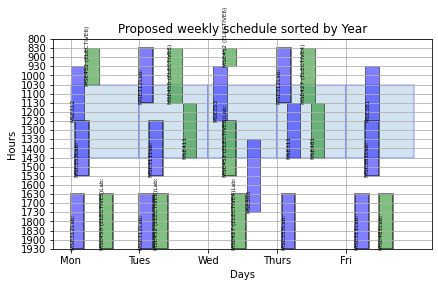

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

def make_weekly_schedule(setcourses, schedule, sortby):
    unique = []
    for i in setcourses: # grab unique set of organizers
        unique.append(setcourses[i][sortby])
    unique = set(unique)
    unique = list(unique)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','darkmagenta','turquoise','seagreen']
    colors = colors[:len(unique)]
    num = len(setcourses)/2
    days = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri']
    numdays = [float(x) for x in range(0,5)]
    numdays = np.array(numdays)

    lunchend = [1050]*5
    lunchdur = [400]*5
    bars = plt.bar(numdays, lunchdur, bottom = lunchend, label = '"lunch time"', alpha = 0.2, edgecolor = 'b', linewidth = 2, width = 1, align = 'edge')
    
    for k in setcourses:
        if setcourses[k]['schedule'] != '':
            i = schedule[setcourses[k]['Weekly Class Duration'] + setcourses[k]['Weekly Tutorial Duration']][setcourses[k]['schedule']]
            duration = []
            endtime = []
            duration_lab = []
            endtime_lab = []
            
            for j in days:    
                dur = int(i[j+' End'] - i[j+' Start'])
                end = int(i[j+' Start'])
                duration.append(dur)
                endtime.append(end)
                if dur!=0: #print class label
                    plt.text(numdays[days.index(j)], end+dur, k, rotation = 'vertical', fontsize = 'xx-small')

                if len(setcourses[k]['lab schedule']) != 0:
                    for l in setcourses[k]['lab schedule']:
                        lab = schedule[setcourses[k]['Lab Constraint']][l]
                        # lab = schedule[setcourses[k]['Lab Constraint']][setcourses[k]['lab schedule']]
                        durlab = int(lab[j+' End'] - lab[j+' Start'])
                        endlab = int(lab[j+' Start'])
                        if durlab !=0:
                            # print(k+' lab', j, endlab, durlab)
                            plt.text(numdays[days.index(j)], endlab+durlab, k+'Lab: ', rotation = 'vertical', fontsize = 'xx-small')
                            bars = plt.bar(numdays[days.index(j)], durlab, bottom = endlab, label = k, alpha = 0.5, edgecolor = 'k', linewidth = 2, width = 1/num, align = 'edge', color = colors[unique.index(setcourses[k][sortby])])
                    duration_lab.append(durlab)
                    endtime_lab.append(endlab)
                            

                
            bars = plt.bar(numdays, duration, bottom = endtime, label = k, alpha = 0.5, edgecolor = 'k', linewidth = 1, width = 1/num, align = 'edge', color = colors[unique.index(setcourses[k][sortby])])
            # if setcourses[k]['Weekly Lab Duration'] != 0:
            #     bars = plt.bar(numdays, duration_lab, bottom = endtime_lab, label = k, alpha = 0.5, edgecolor = 'b', linewidth = 2, width = 1/num, align = 'edge', color = colors[unique.index(setcourses[k][sortby])])
            numdays+=0.07 #HACKY way of offsetting horizontal displacement to show overlaying schedules
    ytick = [x*100+y for x in range(8,20) for y in [0,30]]
    plt.ylim(1950, 850)
    plt.grid(True, which = 'both', axis = 'both')
    plt.tight_layout()
    plt.yticks(range(800,2000,50), labels = ytick) #hacky
    plt.xticks([x for x in range(0,5)], labels = days)
    plt.title('Proposed weekly schedule sorted by '+sortby)
    plt.ylabel('Hours')
    plt.xlabel('Days')
    plt.show()

make_weekly_schedule(a.best_set, schedule, 'Year')

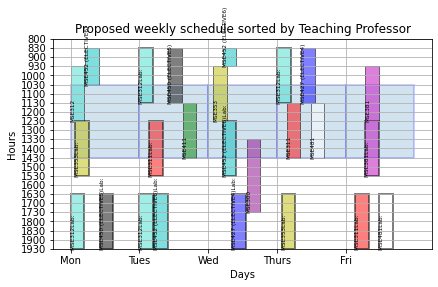

In [29]:
make_weekly_schedule(a.best_set, schedule, 'Teaching Professor')

# 4/23: Basic Conflicts Resolved  
To implement:  
3) Add Lab hours  
4) Optimize based on constraint 4,5  
return solution if found to satisfy all constraints, including soft  
continue search if optimal solution not found  
return list of all partial solutions, rank by performance metric (to be designed)  
5) benchmark soln search based on # nodes expanded
